# Run meta-analyses on 21 pain studies
Collection of NIDM-Results packs downloaded from Neurovault collection [1425](https://www.neurovault.org/collections/1425/), uploaded by Dr. Camille Maumet.

In [1]:
%matplotlib inline
import json
import numpy as np
from glob import glob
from os.path import basename, join, dirname, isfile

import pandas as pd
import nibabel as nib
from scipy.stats import t
from nilearn.masking import apply_mask
from nilearn.plotting import plot_stat_map

import nimare
from nimare.meta.ibma import (stouffers, fishers, weighted_stouffers,
                              rfx_glm, ffx_glm, mfx_glm)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/duecredit/utils.py:32: PendingDeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \


In [2]:
dset_file = '../nimare/resources/nidm_pain_dset_with_subpeaks_docker.json'
with open(dset_file, 'r') as fo:
    dset_dict = json.load(fo)
db = nimare.dataset.Database(dset_file)
dset = db.get_dataset()

mask_img = dset.mask

logp_thresh = -np.log(.05)

## Define functions for querying set of NIDM-Results packs

In [3]:
def _get_file(cdict, t):
    """Return the file associated with a given data type within a
    folder if it exists. Otherwise, returns an empty list.
    """
    temp = ''
    if t == 'con':
        temp = cdict['images'].get('con')
    elif t == 'se':
        temp = cdict['images'].get('se')
    elif t == 't':
        temp = cdict['images'].get('t')
    elif t == 'z':
        temp = cdict['images'].get('z')
    elif t == 'n':
        temp = cdict.get('sample_sizes', [])
        if temp:
            temp = np.mean(temp)
    else:
        raise Exception('Input type "{0}" not recognized.'.format(t))

    return temp


def get_files(ddict, types):
    """Returns a list of files associated with a given data type 
    from a set of subfolders within a directory. Allows for
    multiple data types and only returns a set of files from folders
    with all of the requested types.
    """
    all_files = []
    for study in ddict.keys():
        files = []
        cdict = ddict[study]['contrasts']['1']
        for t in types:
            temp = _get_file(cdict, t)
            if temp:
                files.append(temp)
            
        if len(files) == len(types):
            all_files.append(files)
    all_files = list(map(list, zip(*all_files)))
    return all_files

## Get z-maps

In [4]:
files = get_files(dset_dict, ['z'])
z_imgs = [nib.load(f) for f in files[0]]
z_data = apply_mask(z_imgs, mask_img)
print('{0} studies found.'.format(z_data.shape[0]))

11 studies found.


## Fisher's

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


CPU times: user 1.41 s, sys: 210 ms, total: 1.62 s
Wall time: 1.5 s


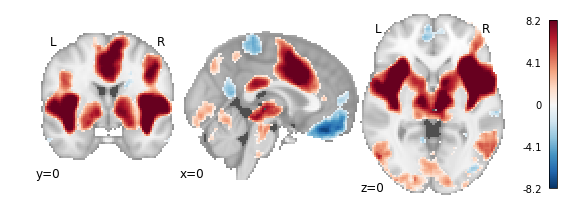

In [5]:
%%time
result = fishers(z_data, mask_img)
plot_stat_map(result.images['z'],
              cut_coords=[0, 0, 0], draw_cross=False,
              cmap='RdBu_r')

## Stouffer's

### Fixed-effects inference

CPU times: user 1.06 s, sys: 150 ms, total: 1.21 s
Wall time: 1.08 s


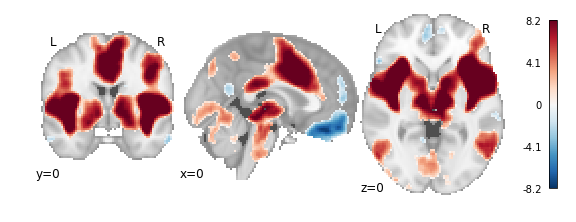

In [6]:
%%time
result = stouffers(z_data, mask_img, inference='ffx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['z'],
              cut_coords=[0, 0, 0], draw_cross=False,
              cmap='RdBu_r')

### Random-effects inference with theoretical null distribution

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 1.23 s, sys: 150 ms, total: 1.38 s
Wall time: 1.23 s


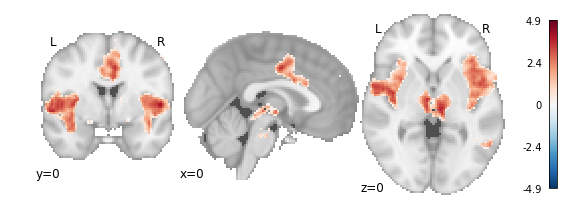

In [7]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['z'],
              cut_coords=[0, 0, 0], draw_cross=False,
              cmap='RdBu_r')

### Random-effects inference with empirical null distribution

CPU times: user 16.9 s, sys: 140 ms, total: 17.1 s
Wall time: 17 s


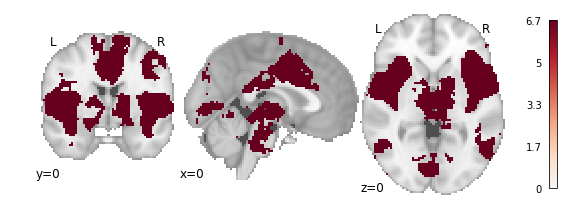

In [8]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='empirical', n_iters=100)
plot_stat_map(result.images['z'],
              cut_coords=[0, 0, 0], draw_cross=False,
              cmap='RdBu_r')

## Get z-maps + sample sizes

In [9]:
z_files, ns = get_files(dset_dict, ['z', 'n'])
z_imgs = [nib.load(f) for f in z_files]
z_data = apply_mask(z_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(z_data.shape[0]))

11 studies found.


## Weighted Stouffer's

CPU times: user 1.15 s, sys: 120 ms, total: 1.27 s
Wall time: 1.15 s


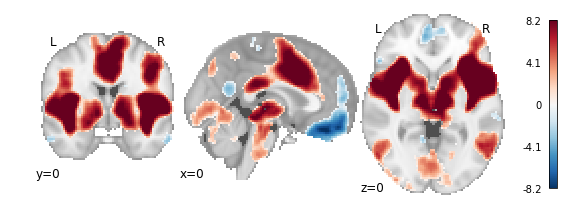

In [10]:
%%time
result = weighted_stouffers(z_data, sample_sizes, mask_img)
plot_stat_map(result.images['z'],
              cut_coords=[0, 0, 0], draw_cross=False,
              cmap='RdBu_r')

## Get contrast maps + contrast standard error maps + sample sizes

In [11]:
con_files, se_files, ns = get_files(dset_dict, ['con', 'se', 'n'])
con_imgs = [nib.load(f) for f in con_files]
se_imgs = [nib.load(f) for f in se_files]
con_data = apply_mask(con_imgs, mask_img)
se_data = apply_mask(se_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(con_data.shape[0]))

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


21 studies found.


## FFX GLM

190113-17:17:25,586 nipype.interface INFO:
	 stdout 2019-01-13T17:17:25.585824:Log directory is: stats
190113-17:17:25,591 nipype.interface INFO:
	 stdout 2019-01-13T17:17:25.591059:Setting up:
190113-17:17:27,60 nipype.interface INFO:
	 stdout 2019-01-13T17:17:27.060086:ntptsing=21.000000 
190113-17:17:27,66 nipype.interface INFO:
	 stdout 2019-01-13T17:17:27.060086:
190113-17:17:27,76 nipype.interface INFO:
	 stdout 2019-01-13T17:17:27.060086:evs_group=1.000000 
190113-17:17:27,88 nipype.interface INFO:
	 stdout 2019-01-13T17:17:27.060086:
190113-17:17:27,91 nipype.interface INFO:
	 stdout 2019-01-13T17:17:27.091642:No f contrasts
190113-17:17:27,250 nipype.interface INFO:
	 stdout 2019-01-13T17:17:27.250375:
190113-17:17:27,256 nipype.interface INFO:
	 stdout 2019-01-13T17:17:27.250375:WARNING: The passed in varcope file, /home/neuro/code/NiMARE/examples/mfx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the ana

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


CPU times: user 9.79 s, sys: 730 ms, total: 10.5 s
Wall time: 20.7 s


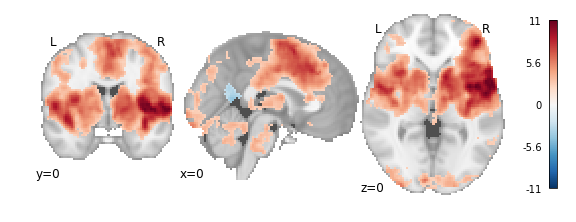

In [12]:
%%time
result = ffx_glm(con_data, se_data, sample_sizes, mask_img)
plot_stat_map(result.images['thresh_z'],
              cut_coords=[0, 0, 0], draw_cross=False,
              cmap='RdBu_r')

## MFX GLM

190113-17:17:46,748 nipype.interface INFO:
	 stdout 2019-01-13T17:17:46.748093:Log directory is: stats
190113-17:17:46,776 nipype.interface INFO:
	 stdout 2019-01-13T17:17:46.776426:Setting up:
190113-17:17:48,362 nipype.interface INFO:
	 stdout 2019-01-13T17:17:48.362183:ntptsing=21.000000 
190113-17:17:48,364 nipype.interface INFO:
	 stdout 2019-01-13T17:17:48.362183:
190113-17:17:48,373 nipype.interface INFO:
	 stdout 2019-01-13T17:17:48.362183:evs_group=1.000000 
190113-17:17:48,376 nipype.interface INFO:
	 stdout 2019-01-13T17:17:48.362183:
190113-17:17:48,379 nipype.interface INFO:
	 stdout 2019-01-13T17:17:48.379819:No f contrasts
190113-17:17:48,534 nipype.interface INFO:
	 stdout 2019-01-13T17:17:48.533876:
190113-17:17:48,537 nipype.interface INFO:
	 stdout 2019-01-13T17:17:48.533876:WARNING: The passed in varcope file, /home/neuro/code/NiMARE/examples/mfx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from th

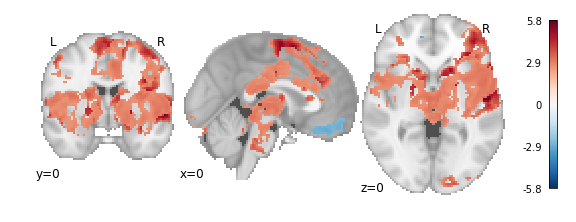

In [13]:
%%time
result = mfx_glm(con_data, se_data, sample_sizes, mask_img)
plot_stat_map(result.images['thresh_z'],
              cut_coords=[0, 0, 0], draw_cross=False,
              cmap='RdBu_r')

## Get contrast maps

In [14]:
con_files = get_files(dset_dict, ['con'])
con_files = con_files[0]
con_imgs = [nib.load(f) for f in con_files]
con_data = apply_mask(con_imgs, mask_img)
print('{0} studies found.'.format(con_data.shape[0]))

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


21 studies found.


## RFX GLM

### Theoretical null distribution

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 1.68 s, sys: 120 ms, total: 1.8 s
Wall time: 1.66 s


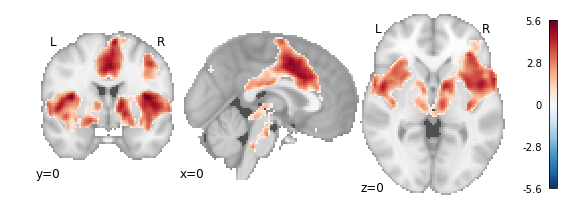

In [15]:
%%time
result = rfx_glm(con_data, mask_img, null='theoretical', n_iters=None)
plot_stat_map(result.images['z'],
              cut_coords=[0, 0, 0], draw_cross=False,
              cmap='RdBu_r')

### Empirical null distribution

CPU times: user 20.8 s, sys: 140 ms, total: 21 s
Wall time: 20.9 s


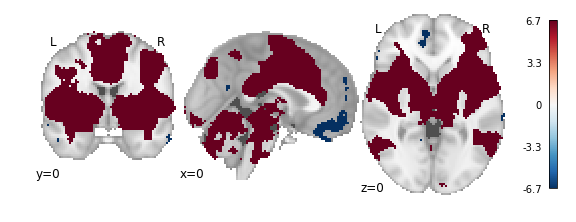

In [16]:
%%time
result = rfx_glm(con_data, mask_img, null='empirical', n_iters=100)
plot_stat_map(result.images['z'],
              cut_coords=[0, 0, 0], draw_cross=False,
              cmap='RdBu_r')

## MKDA

### Density analysis

CPU times: user 2.45 s, sys: 630 ms, total: 3.08 s
Wall time: 13 s


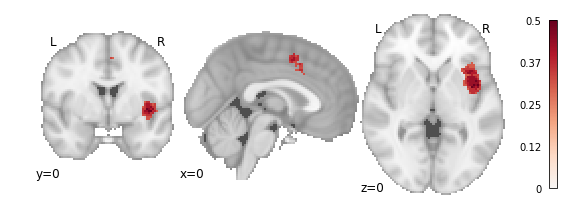

In [17]:
%%time
mkda = nimare.meta.cbma.MKDADensity(dset, ids=dset.ids, kernel__r=10)
mkda.fit(n_iters=10)
plot_stat_map(mkda.results.images['vfwe'],
              cut_coords=[0, 0, 0],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FDR correction

/home/neuro/code/NiMARE/nimare/meta/cbma/mkda.py:212: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


CPU times: user 5.05 s, sys: 230 ms, total: 5.28 s
Wall time: 5.17 s


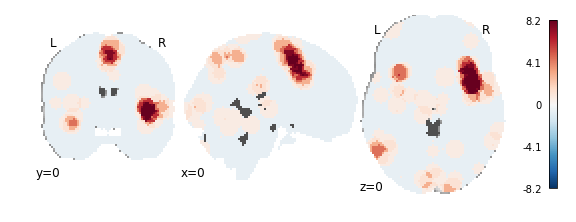

In [18]:
%%time
mkda2 = nimare.meta.cbma.MKDAChi2(dset, ids=dset.ids, ids2=dset.ids, kernel__r=10)
mkda2.fit(corr='FDR')
plot_stat_map(mkda2.results.images['consistency_z_FDR'],
              cut_coords=[0, 0, 0],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FWE correction

Now running iteration 0


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


CPU times: user 10.6 s, sys: 500 ms, total: 11.1 s
Wall time: 16.4 s


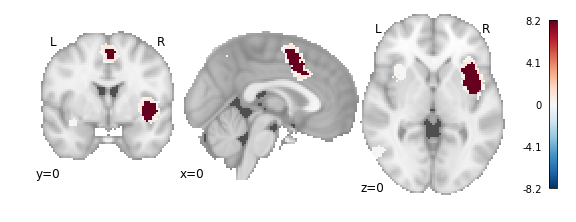

In [19]:
%%time
mkda3 = nimare.meta.cbma.MKDAChi2(dset, ids=dset.ids, ids2=dset.ids, kernel__r=10)
mkda3.fit(corr='FWE', n_iters=10)
plot_stat_map(mkda3.results.images['consistency_z_FWE'],
              cut_coords=[0, 0, 0],
              draw_cross=False, cmap='RdBu_r')

## KDA

CPU times: user 1.46 s, sys: 340 ms, total: 1.8 s
Wall time: 12.8 s


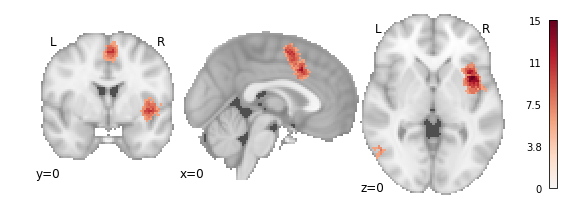

In [20]:
%%time
kda = nimare.meta.cbma.KDA(dset, ids=dset.ids, kernel__r=10)
kda.fit(n_iters=10)
plot_stat_map(kda.results.images['vfwe'],
              cut_coords=[0, 0, 0],
              draw_cross=False, cmap='RdBu_r')

## ALE

CPU times: user 6.71 s, sys: 670 ms, total: 7.38 s
Wall time: 18.2 s


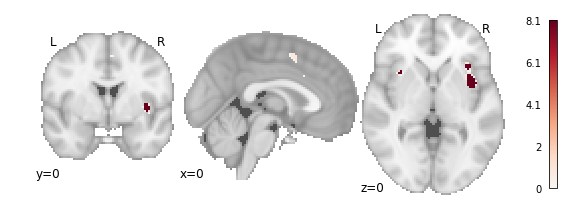

In [21]:
%%time
ale = nimare.meta.cbma.ALE(dset, ids=dset.ids)
ale.fit(n_iters=10)
plot_stat_map(ale.results.images['z_vfwe'],
              cut_coords=[0, 0, 0],
              draw_cross=False, cmap='RdBu_r')

## SCALE

In [22]:
# SCALE is crashing the kernel within Docker, so we'll skip it for now
#%%time
#ijk = np.vstack(np.where(dset.mask.get_data())).T
#scale = nimare.meta.cbma.SCALE(dset, ids=dset.ids, ijk=ijk)
#scale.fit(n_iters=10)
#plot_stat_map(scale.results.images['vthresh'],
#              cut_coords=[0, 0, 0],
#              draw_cross=False, cmap='RdBu_r')